In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import pandas as pd
import re
import random
import string
import matplotlib.pyplot as plt
from utilities import clean_arabic_tweet
from utilities import remove_repeating_char, remove_punctuations, remove_diacritics, normalize_arabic, remove_single_char_word
from utilities import remove_common_words, remove_duplicate_words, remove_rare_words, clean_arabic_tweetV0
from utilities import farasa_segmenting, loading_stopwords_from_file, remove_stopwords, get_tweet_lengths
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tqdm import tqdm
from collections import OrderedDict
import utilities as utils
from sklearn.cluster import KMeans
import copy
from sklearn.model_selection import train_test_split

[2021-02-13 22:26:33,150 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [3]:
pd.set_option('display.max_colwidth', -1)

# Data Preprocessing

## Loading Train Data

In [4]:
train_data_path = './data/DA_train_labeled.tsv'
test_data_path = './data/DA_dev_labeled.tsv'

In [5]:
train_data = pd.read_csv(train_data_path, sep='\t')
test_data = pd.read_csv(test_data_path, sep='\t')

## Delete province_labels 

In [6]:
del train_data['#4_province_label']
del test_data['#4_province_label']

## Plot tweets ferquency for every country

<AxesSubplot:>

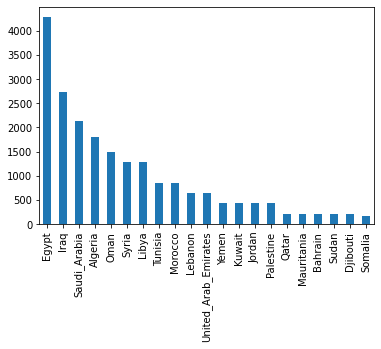

In [7]:
fig, ax = plt.subplots()
train_data['#3_country_label'].value_counts().plot(ax=ax, kind='bar')

<AxesSubplot:>

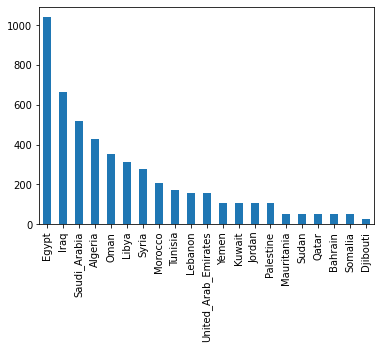

In [8]:
fig, ax = plt.subplots()
test_data['#3_country_label'].value_counts().plot(ax=ax, kind='bar')

In [9]:
# test_data['#3_country_label'].value_counts()

In [10]:
# train_data['#3_country_label'].value_counts()

## preview samples 

In [11]:
# train_data.loc[train_data['#3_country_label'] == 'Somalia']

## clean tweets

### V0 cleaning

In [12]:
# '''
# v0 cleaning is just:
#     removing english chars and punctuations
#     replace('،', '')
#     replace('"', '')
#     replace('-', ' ')
#     replace('—', ' ')
#     replace('_', ' ')
#     replace('+', ' ')
#     replace('#', '')
# '''

In [13]:
train_data['#2_tweet_clean_V0'] = (train_data['#2_tweet'].apply(clean_arabic_tweetV0))
test_data['#2_tweet_clean_V0'] = (test_data['#2_tweet'].apply(clean_arabic_tweetV0))

### farasa on V0 

In [14]:
# '''
# farasa segementation is applying arabic segmentation on v0
# '''

In [15]:
train_data['#2_tweet_clean_farasaV0'] = (train_data['#2_tweet_clean_V0'].apply(farasa_segmenting))
test_data['#2_tweet_clean_farasaV0'] = (test_data['#2_tweet_clean_V0'].apply(farasa_segmenting))

### V1 cleaning

In [16]:
# '''
#     v1 cleaning :

#     # step 1 remove punctuations

#     # step 2 remove english chars

#     # step 3 remove diacritics
    
#     # step 4 normalize arabic

#     # step 5 some of chars unicode still leaks into the text 
#     # filter the text char by char
    
#     # step 6  removing words which contains single char 

# '''

In [17]:
tarin_tweets_cleaned = (train_data['#2_tweet'].apply(clean_arabic_tweet))
test_tweets_cleaned = (test_data['#2_tweet'].apply(clean_arabic_tweet))

In [18]:
train_data['#2_tweet_clean_V1']= tarin_tweets_cleaned
test_data['#2_tweet_clean_V1']= test_tweets_cleaned

### v2 cleaning

In [19]:
# '''
# removing stop words from V1
# '''

In [20]:
stop_words_list_preprocessed = loading_stopwords_from_file(file_name='formal clitics stop words.txt')

In [21]:
train_data['#2_tweet_clean_V2']= train_data['#2_tweet_clean_V1'].apply(remove_stopwords)
    
test_data['#2_tweet_clean_V2']= test_data['#2_tweet_clean_V1'].apply(remove_stopwords)

In [22]:
len(utils.removed_stop_words)

47992

### v3 cleaning

In [23]:
'''
remove duplicate words on V2
remove rare words on V2
remove common words
'''

'\nremove duplicate words on V2\nremove rare words on V2\nremove common words\n'

In [24]:
train_data['#2_tweet_clean_V3'] = remove_duplicate_words(train_data['#2_tweet_clean_V2'])
test_data['#2_tweet_clean_V3']= remove_duplicate_words(test_data['#2_tweet_clean_V2'])


train_data['#2_tweet_clean_V3']= remove_rare_words(train_data['#2_tweet_clean_V3'], 1)
test_data['#2_tweet_clean_V3']= remove_rare_words(test_data['#2_tweet_clean_V3'], 1)


train_data['#2_tweet_clean_V3'] = remove_common_words(train_data['#2_tweet_clean_V3'], 0.90)
test_data['#2_tweet_clean_V3']= remove_common_words(test_data['#2_tweet_clean_V3'], 0.90)


words removed:  0
words removed:  0
words_count 140995
minimum_words 126895.5
words_count 33415
minimum_words 30073.5


#### delete empty tweets

In [25]:
def remove_empty_tweets(df, column_name):
    nan_value = float("NaN")
    df.replace("", nan_value, inplace=True)
    df.dropna(subset = [column_name], inplace=True)
    return df


In [26]:
remove_empty_tweets(train_data, "#2_tweet_clean_V1")
remove_empty_tweets(train_data, "#2_tweet_clean_V2")
remove_empty_tweets(train_data, "#2_tweet_clean_V3")

remove_empty_tweets(test_data, "#2_tweet_clean_V1")
remove_empty_tweets(test_data, "#2_tweet_clean_V2")
remove_empty_tweets(test_data, "#2_tweet_clean_V3")

,#1_tweetid,#2_tweet,#3_country_label,#2_tweet_clean_V0,#2_tweet_clean_farasaV0,#2_tweet_clean_V1,#2_tweet_clean_V2,#2_tweet_clean_V3
0,DEV_0,قولنا اون لاين لا يا علي اون لاين لا,Egypt,قولنا اون لاين لا يا علي اون لاين لا,قول نا اون لاين لا يا علي اون لاين لا,قولنا اون لاين لا يا علي اون لاين لا,قولنا اون لاين يا اون لاين,قولنا اون لاين يا
1,DEV_1,ههههه بايخه ههههه URL …,Oman,ههههه بايخه ههههه,ههههه بايخ ه ههههه,بايخه,بايخه,بايخه
2,DEV_2,ربنا يخليك يا دوك ولك المثل :D,Lebanon,ربنا يخليك يا دوك ولك المثل,رب نا يخليك يا دوك و لك ال مثل,ربنا يخليك يا دوك ولك المثل,ربنا يخليك يا دوك ولك المثل,ربنا يخليك يا دوك ولك المثل
3,DEV_3,#اوامر_ملكيه ياشباب اي واحد فيكم عنده شي يذكره بالعساف يجيبه له احرقه,Syria,اوامر ملكيه ياشباب اي واحد فيكم عنده شي يذكره بالعساف يجيبه له احرقه,أوامر ملكي ه ياشباب اي واحد في كم عند ه شي يذكر ه ب ال عساف يجيب ه ل ه احرق ه,اوامر ملكيه ياشباب اي واحد فيكم عنده شي يذكره بالعساف يجيبه له احرقه,اوامر ملكيه ياشباب فيكم عنده شي يذكره بالعساف يجيبه احرقه,اوامر ملكيه ياشباب فيكم عنده شي يذكره بالعساف يجيبه احرقه
4,DEV_4,شد عالخط حتى هيا اكويسه,Libya,شد عالخط حتى هيا اكويسه,شد عالخط حتى هيا اكويسه,شد عالخط حتى هيا اكويسه,شد عالخط اكويسه,شد عالخط اكويسه
...,...,...,...,...,...,...,...,...
4995,DEV_4995,و في الشتاء مستحيل يقب,Libya,و في الشتاء مستحيل يقب,و في ال شتاء مستحيل يقب,في الشتاء مستحيل يقب,الشتاء مستحيل يقب,الشتاء مستحيل يقب
4996,DEV_4996,اكيد حبيبتي وانتِ في كيفك وكيف طيبة قلبك,Libya,اكيد حبيبتي وانتِ في كيفك وكيف طيبة قلبك,أكيد حبيب ت ي و أنت في كيف ك و كيف طيب ة قلب ك,اكيد حبيبتي وانت في كيفك وكيف طيبه قلبك,اكيد حبيبتي وانت كيفك وكيف طيبه قلبك,اكيد حبيبتي وانت كيفك وكيف طيبه قلبك
4997,DEV_4997,يسعد صباح الناس رايقه,Jordan,يسعد صباح الناس رايقه,يسعد صباح ال ناس رايق ه,يسعد صباح الناس رايقه,يسعد الناس رايقه,يسعد الناس رايقه
4998,DEV_4998,فرحتهم فيهاا ياتقبرنييي USER .twitter.com/hUSuYYoE1b,Morocco,فرحتهم فيهاا ياتقبرنييي,فرح ت هم فيها ا ياتقبرنييي,فرحتهم فيها ياتقبرني,فرحتهم ياتقبرني,فرحتهم ياتقبرني


#### add class id coloumn

In [27]:
classes_names = train_data['#3_country_label'].unique().tolist()
classes_map={}
for i,class_name in enumerate(classes_names):
    classes_map[class_name]=i


def find_class_id_from_name(class_name):
    return classes_map[class_name]

In [28]:
train_data['#classes_id']=train_data['#3_country_label'].apply(find_class_id_from_name)
test_data['#classes_id']=test_data['#3_country_label'].apply(find_class_id_from_name)

In [29]:
train_data.head(20)

,#1_tweetid,#2_tweet,#3_country_label,#2_tweet_clean_V0,#2_tweet_clean_farasaV0,#2_tweet_clean_V1,#2_tweet_clean_V2,#2_tweet_clean_V3,#classes_id
0,TRAIN_0,حاجة حلوة اكيد,Egypt,حاجة حلوة اكيد,حاج ة حلو ة أكيد,حاجه حلوه اكيد,حاجه حلوه اكيد,حاجه حلوه اكيد,0
1,TRAIN_1,عم بشتغلوا للشعب الاميركي اما نحن يكذبوا ويغشوا ويسرقوا ويقتلو شعوبهم ويعملوا لصالح اعدائهم,Iraq,عم بشتغلوا للشعب الاميركي اما نحن يكذبوا ويغشوا ويسرقوا ويقتلو شعوبهم ويعملوا لصالح اعدائهم,عم بشتغلوا ل ال شعب ال أميركي اما نحن يكذب وا و يغش وا و يسرق وا و يقتلو شعوب هم و يعمل وا ل صالح اعدائ هم,عم بشتغلوا لشعب الاميركي اما نحن يكذبوا ويغشوا ويسرقوا ويقتلو شعوبهم ويعملوا لصالح اعداهم,عم بشتغلوا لشعب الاميركي يكذبوا ويغشوا ويسرقوا ويقتلو شعوبهم ويعملوا لصالح اعداهم,عم بشتغلوا لشعب الاميركي يكذبوا ويغشوا ويسرقوا ويقتلو شعوبهم ويعملوا لصالح اعداهم,1
2,TRAIN_2,ابشر طال عمرك,Saudi_Arabia,ابشر طال عمرك,ابشر طال عمر ك,ابشر طال عمرك,ابشر طال عمرك,ابشر طال عمرك,2
3,TRAIN_3,منطق 2017: أنا والغريب علي إبن عمي وأنا والغريب وإبن عمي علي أخويا. #قطع_العلاقات_مع_قطر #موريتانيا_مع_قطر,Mauritania,منطق أنا والغريب علي إبن عمي وأنا والغريب وإبن عمي علي أخويا قطع العلاقات مع قطر موريتانيا مع قطر,منطق أنا و ال غريب علي إبن عمي و أنا و ال غريب و إبن عمي علي أخوي ا قطع ال علاق ات مع قطر موريتانيا مع قطر,منطق انا والغريب علي ابن عمي وانا والغريب وابن عمي علي اخويا قطع العلاقات مع قطر موريتانيا مع قطر,منطق والغريب ابن عمي وانا والغريب وابن عمي اخويا قطع العلاقات قطر موريتانيا قطر,منطق والغريب ابن عمي وانا وابن اخويا قطع العلاقات قطر موريتانيا,3
4,TRAIN_4,شهرين وتروح والباقي غير صيف ملينا,Algeria,شهرين وتروح والباقي غير صيف ملينا,شهر ين و تروح و ال باقي غير صيف ملي نا,شهرين وتروح والباقي غير صيف ملينا,شهرين وتروح والباقي صيف ملينا,شهرين وتروح والباقي صيف ملينا,4
5,TRAIN_5,يابنتى والله ما حد متغاظ ولا مفروس منك ولا بيحسدك انتى عره اساسا.,Syria,يابنتى والله ما حد متغاظ ولا مفروس منك ولا بيحسدك انتى عره اساسا,يابنتى و الله ما حد متغاظ و لا مفروس من ك و لا بيحسدك انتى عر ه اساس ا,يابنتى واله ما حد متغاظ ولا مفروس منك ولا بيحسدك انتى عره اساسا,يابنتى واله حد متغاظ مفروس منك بيحسدك انتى عره اساسا,يابنتى واله حد متغاظ مفروس منك بيحسدك انتى عره اساسا,5
6,TRAIN_6,نفس الوقت بأكد على صاحبتي ان اي هدف هتحطه وتخططله هيبوظ والأفضل التشاؤم واننا نتوقع الأسوء دايما والفشل عشان منعشمش نفسنا ع الفاضي,Egypt,نفس الوقت بأكد على صاحبتي ان اي هدف هتحطه وتخططله هيبوظ والأفضل التشاؤم واننا نتوقع الأسوء دايما والفشل عشان منعشمش نفسنا ع الفاضي,نفس ال وقت ب أكد على صاحب ت ي ان اي هدف هتحطه وتخططله هيبوظ و ال أفضل ال تشاؤم وان نا نتوقع ال أسوء دائم ا و ال فشل عشان منعشمش نفس نا ع ال فاضي,نفس الوقت باكد على صاحبتي ان اي هدف هتحطه وتخطله هيبوظ والافضل التشام وانا نتوقع الاسوء دايما والفشل عشان منعشمش نفسنا الفاضي,باكد صاحبتي هدف هتحطه وتخطله هيبوظ والافضل التشام وانا نتوقع الاسوء دايما والفشل عشان منعشمش نفسنا الفاضي,باكد صاحبتي هدف هتحطه وتخطله هيبوظ والافضل التشام وانا نتوقع الاسوء دايما والفشل عشان منعشمش نفسنا الفاضي,0
7,TRAIN_7,م تبطلي خرا بقا علشان مطلعهوش عليكي احترمي نفسك URL …,Egypt,م تبطلي خرا بقا علشان مطلعهوش عليكي احترمي نفسك,م تبطلي خر ا بق ا علشان مطلعهوش عليكي احترم ي نفس ك,تبطلي خرا بقا علشان مطلعهوش عليكي احترمي نفسك,تبطلي خرا بقا علشان مطلعهوش عليكي احترمي نفسك,تبطلي خرا بقا علشان مطلعهوش عليكي احترمي نفسك,0
8,TRAIN_8,ما يله دخل !,Oman,ما يله دخل,ما يله دخل,ما يله دخل,يله دخل,يله دخل,6
9,TRAIN_9,هو حلو بس يتخربط ع طلاب المدراس ليك مايغيرونه عدنا,Iraq,هو حلو بس يتخربط ع طلاب المدراس ليك مايغيرونه عدنا,هو حلو بس يتخربط ع طلاب ال مدراس ليك مايغيرونه عد نا,هو حلو بس يتخربط طلاب المدراس ليك مايغيرونه عدنا,حلو يتخربط طلاب المدراس ليك مايغيرونه عدنا,حلو يتخربط طلاب المدراس ليك مايغيرونه عدنا,1


In [30]:
test_data.head(10)

,#1_tweetid,#2_tweet,#3_country_label,#2_tweet_clean_V0,#2_tweet_clean_farasaV0,#2_tweet_clean_V1,#2_tweet_clean_V2,#2_tweet_clean_V3,#classes_id
0,DEV_0,قولنا اون لاين لا يا علي اون لاين لا,Egypt,قولنا اون لاين لا يا علي اون لاين لا,قول نا اون لاين لا يا علي اون لاين لا,قولنا اون لاين لا يا علي اون لاين لا,قولنا اون لاين يا اون لاين,قولنا اون لاين يا,0
1,DEV_1,ههههه بايخه ههههه URL …,Oman,ههههه بايخه ههههه,ههههه بايخ ه ههههه,بايخه,بايخه,بايخه,6
2,DEV_2,ربنا يخليك يا دوك ولك المثل :D,Lebanon,ربنا يخليك يا دوك ولك المثل,رب نا يخليك يا دوك و لك ال مثل,ربنا يخليك يا دوك ولك المثل,ربنا يخليك يا دوك ولك المثل,ربنا يخليك يا دوك ولك المثل,8
3,DEV_3,#اوامر_ملكيه ياشباب اي واحد فيكم عنده شي يذكره بالعساف يجيبه له احرقه,Syria,اوامر ملكيه ياشباب اي واحد فيكم عنده شي يذكره بالعساف يجيبه له احرقه,أوامر ملكي ه ياشباب اي واحد في كم عند ه شي يذكر ه ب ال عساف يجيب ه ل ه احرق ه,اوامر ملكيه ياشباب اي واحد فيكم عنده شي يذكره بالعساف يجيبه له احرقه,اوامر ملكيه ياشباب فيكم عنده شي يذكره بالعساف يجيبه احرقه,اوامر ملكيه ياشباب فيكم عنده شي يذكره بالعساف يجيبه احرقه,5
4,DEV_4,شد عالخط حتى هيا اكويسه,Libya,شد عالخط حتى هيا اكويسه,شد عالخط حتى هيا اكويسه,شد عالخط حتى هيا اكويسه,شد عالخط اكويسه,شد عالخط اكويسه,13
5,DEV_5,انا صاحي ميت مالضحك ايه داااااا,Egypt,انا صاحي ميت مالضحك ايه داااااا,أنا صاحي ميت مالضحك أي داااااا,انا صاحي ميت مالضحك ايه دا,صاحي ميت مالضحك دا,صاحي ميت مالضحك دا,0
6,DEV_6,لا مين أنتِ؟ ههههههههههههههههههههههههههههههههههههههههههههههههههههههه .,Saudi_Arabia,لا مين أنتِ ههههههههههههههههههههههههههههههههههههههههههههههههههههههه,لا مين أنت ههههههههههههههههههههههههههههههههههههههههههههههههههههههه,لا مين انت,مين,مين,2
7,DEV_7,جاي عبالي رشوف,Palestine,جاي عبالي رشوف,جاي عبال ي رشوف,جاي عبالي رشوف,جاي عبالي رشوف,جاي عبالي رشوف,17
8,DEV_8,"""\""ان شاء الله تببوا إلي وإبقى إلكن كل العمر \"" أمينن يارب URL """,Morocco,ان شاء الله تببوا إلي وإبقى إلكن كل العمر أمينن يارب,ان شاء الله تبب وا إلي و إبقى إلكن كل ال عمر أمين ن يارب,ان شاء اله تبوا الي وابقى الكن كل العمر امين يارب,شاء اله تبوا وابقى الكن العمر يارب,شاء اله تبوا وابقى الكن العمر يارب,9
9,DEV_9,الله يلعنك انت اصلا مريض انتزعت من قلبك الرحه URL …,Egypt,الله يلعنك انت اصلا مريض انتزعت من قلبك الرحه,الله يلعنك أنت أصل ا مريض انتزع ت من قلب ك ال رحه,اله يلعنك انت اصلا مريض انتزعت من قلبك الرحه,اله يلعنك مريض انتزعت قلبك الرحه,اله يلعنك مريض انتزعت قلبك الرحه,0


## save the cleaned data

In [31]:
train_data.to_csv("./cleaned_data/cleaned_train_data_for_subtask1.csv", index=False)
test_data.to_csv("./cleaned_data/cleaned_test_data_for_subtask1.csv", index=False)

## get unique words - vocab

In [32]:
# vocab = []
# for tweet in tqdm(train_data['#2_tweet_clean_farasaV0'].tolist()):
#     for word in  text_to_word_sequence(tweet):
#         if word not in vocab:
#             vocab.append(word)


In [33]:
# len(vocab)

## find unique vocab of each country

In [34]:
class_unique_words = {}
for class_name in train_data['#3_country_label'].unique().tolist():
    class_unique_words[class_name] = []

In [35]:
looped = 0
for tweet, class_name in zip(train_data['#2_tweet_clean_V3'].tolist(), train_data['#3_country_label'].tolist()):
    looped+=1
    for word in text_to_word_sequence(tweet):
        if word not in class_unique_words[class_name]:
            exist_in_another_country = False
            for key in class_unique_words.keys():
                if key == class_name:
                    continue
                elif word in class_unique_words[key]:
                    exist_in_another_country = True
                    class_unique_words[key].remove(word)
                    break
            if exist_in_another_country==False:
                class_unique_words[class_name].append(word)

In [36]:
country_name_unique_vocab ={}
country_name, unique_vocab =[], []
for class_name in class_unique_words.keys():
    country_name_unique_vocab[class_name] = len(class_unique_words[class_name])
    country_name.append(class_name)
    unique_vocab.append(len(class_unique_words[class_name]))



In [37]:
country_name_unique_vocab

{'Egypt': 6668,
 'Iraq': 6043,
 'Saudi_Arabia': 4126,
 'Mauritania': 649,
 'Algeria': 4018,
 'Syria': 2795,
 'Oman': 2449,
 'Tunisia': 1830,
 'Lebanon': 1558,
 'Morocco': 2130,
 'Djibouti': 355,
 'United_Arab_Emirates': 978,
 'Kuwait': 758,
 'Libya': 2483,
 'Bahrain': 362,
 'Qatar': 367,
 'Yemen': 895,
 'Palestine': 710,
 'Jordan': 718,
 'Somalia': 271,
 'Sudan': 375}

In [38]:
country_name_unique_vocab_df = df_ = pd.DataFrame(index=range(0,21), columns=['country_name', 'unique_vocab_count'])


In [39]:
country_name_unique_vocab_df['country_name'] = country_name
country_name_unique_vocab_df['unique_vocab_count'] = unique_vocab


In [40]:
country_name_unique_vocab_df.head(21)

,country_name,unique_vocab_count
0,Egypt,6668
1,Iraq,6043
2,Saudi_Arabia,4126
3,Mauritania,649
4,Algeria,4018
5,Syria,2795
6,Oman,2449
7,Tunisia,1830
8,Lebanon,1558
9,Morocco,2130


In [41]:
country_name_unique_vocab_df=country_name_unique_vocab_df.sort_values(by=['unique_vocab_count'], ascending=False)

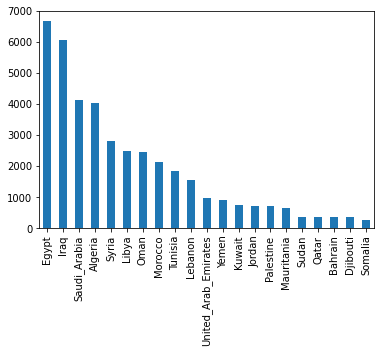

In [42]:
country_name_unique_vocab_df.plot(x='country_name', y='unique_vocab_count', kind='bar',legend=False)
plt.xlabel("")
plt.show()

# spliting X% ratio from each country data to be as validation data 

In [43]:
countries_names = country_name_unique_vocab_df['country_name'].unique().tolist()

In [45]:
# countries_names

### add length of text coloumn 

In [46]:
train_data['#len_of_2_tweet_clean_V0'] = train_data['#2_tweet_clean_V0'].apply(get_tweet_lengths)

In [47]:
kmeans = KMeans(n_clusters=3)


data_frame_for_each_country = {}
for country in countries_names:
    data_frame_for_each_country[country] = train_data[train_data['#3_country_label']==country]
    
    clusterd = kmeans.fit_predict( train_data[train_data['#3_country_label']==country][['#len_of_2_tweet_clean_V0']])

    data_frame_for_each_country[country]['cluster_on_length'] = clusterd



/home/omar/anaconda3/envs/NLP/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/omar/anaconda3/envs/NLP/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/omar/anaconda3/envs/NLP/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy o

/home/omar/anaconda3/envs/NLP/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [48]:
train_frames_list, valid_frames_list = [], []
valid_split_ratio = 0.2
for country in countries_names:
    for cluster in data_frame_for_each_country[country]['cluster_on_length'].unique():
        temp_df = data_frame_for_each_country[country][data_frame_for_each_country[country]['cluster_on_length']==cluster]
        temp_df_shuffled = temp_df.sample(frac=1).reset_index(drop=True)
        train, test = train_test_split(temp_df_shuffled, test_size=valid_split_ratio)
        train_frames_list.append(train)
        valid_frames_list.append(test)

In [49]:
len(train_frames_list)

63

In [50]:
sampled_train_data = pd.concat(train_frames_list).sample(frac=1).reset_index(drop=True)
sampled_valid_data = pd.concat(valid_frames_list).sample(frac=1).reset_index(drop=True)

In [51]:
# sampled_train_data

In [52]:
sampled_train_data.to_csv("./cleaned_data/sample_train_task1.csv", index=False)
sampled_valid_data.to_csv("./cleaned_data/sample_valid_task1.csv", index=False)